# Assam District Analysis
> District Analysis for Assam using seirsplus

- toc: true 
- badges: false
- comments: true
- metadata_key1: metadata_value1
- metadata_key2: metadata_value2

In [1]:
# hide
import contextlib
import io
import json
import random
import sys
import warnings
from pathlib import Path
from typing import List, Union
from urllib.request import urlopen

import altair as alt
import geopandas as gpd
import pandas as pd
from branca.colormap import linear
from IPython.display import Latex, Markdown, display
from IPython.utils import io
from ipywidgets import (
    HTML,
    FloatLogSlider,
    FloatSlider,
    GridBox,
    HBox,
    IntSlider,
    Label,
    Layout,
    Output,
    SelectionSlider,
    VBox,
    interactive,
)
from seirsplus.models import *

warnings.filterwarnings("ignore")

In [2]:
# hide
assam_df = pd.read_csv("AssamDistrictInfo.csv")

In [3]:
# hide
def get_infections(
    initI: int = 100, initN: int = 10 ** 5, days_N: int = 21, beta: float = 2.4
) -> List[int]:
    model = SEIRSModel(
        beta=beta,
        sigma=1 / 5.2,
        gamma=1 / 12.39,
        initN=initN,
        initI=initI,
        beta_D=0.000,
        mu_D=0.02,
        #         sigma_D=1 / 4.0,
        #         gamma_D=1 / 9.0,
        theta_E=0.0002,
        theta_I=0.002,
        psi_E=0.2,
        psi_I=1.0,
    )
    with io.capture_output() as captured:
        model.run(T=days_N)
    S = model.numS  # time series of S counts
    E = model.numE  # time series of E counts
    I = model.numI  # time series of I counts
    D_E = model.numD_E  # time series of D_E counts
    D_I = model.numD_I  # time series of D_I counts
    R = model.numR  # time series of R counts
    F = model.numF  # time series of F counts
    t = model.tseries  # time values corresponding to the above time series
    return {"detected_exposed": D_E, "detected_infected": D_I, "model": model, "t": t}

In [4]:
# hide
def get_risk_estimates(
    assam_estimated_df: pd.DataFrame, beta: float
) -> Union[List, List]:
    days_N = 21
    atrisk_day14, atrisk_day21 = [], []
    for row in assam_estimated_df[["initI", "initN", "district"]].iterrows():
        initI, initN, district = row[1][0], int(row[1][1]), row[1][2]
        #     print(type(initI), type(initN))
        infection_results = get_infections(
            initI=initI, initN=initN, days_N=days_N, beta=beta
        )
        detected_infected = infection_results["detected_infected"]
        day14 = int(14 * len(detected_infected) / days_N)
        case_count_day14 = int(infection_results["detected_infected"][day14])
        case_count_day21 = int(infection_results["detected_infected"][-1])
        atrisk_day14.append(case_count_day14)
        atrisk_day21.append(case_count_day21)
    return atrisk_day14, atrisk_day21, infection_results

In [5]:
# hide_input
# @title Assumptions
percent_travellers_infected = (
    1e-1  # @param {type:"slider", min:0, max:1e-1, step:0.001}
)
unknown_to_known_travelers = 50  # @param {type:"slider", min:5, max:50, step:1}
beta = 5  # @param {type:"slider", min:0.5, max:5.0, step:0.1}

# display(Markdown(f"#Assumptions \npercent_travellers_infected :{percent_travellers_infected}\nunknown_to_known_travelers={unknown_to_known_travelers}\nbeta:{beta} "))

In [6]:
# hide
def estimate(
    percent_travellers_infected: float,
    unknown_to_known_travelers: int,
    beta: float,
    assam_df: pd.DataFrame,
):

    assam_estimated_df = assam_df.copy()
    assam_estimated_df["initI"] = (
        percent_travellers_infected * unknown_to_known_travelers * assam_df["Inflow"]
    ).astype(int)
    assam_estimated_df["initN"] = assam_estimated_df["Population"].astype(int)

    (
        assam_estimated_df[f"day14"],
        assam_estimated_df[f"day21"],
        infection_results,
    ) = get_risk_estimates(assam_estimated_df, beta=beta)
    return assam_estimated_df

In [7]:
# hide
assam_estimated_df = estimate(
    percent_travellers_infected, unknown_to_known_travelers, beta, assam_df
)

In [8]:
# hide
def open_geojson(geo_json_file_loc):
    with urlopen(geo_json_file_loc) as response:
        d = json.load(response)
    return d

In [9]:
# hide
assam_json = open_geojson(
    "https://raw.githubusercontent.com/shklnrj/IndiaStateTopojsonFiles/master/Assam.geojson"
)
gdf = gpd.GeoDataFrame.from_features((assam_json))

In [10]:
# hide
gdf = gdf.merge(
    assam_estimated_df, left_on="Dist_Name", right_on="district", how="inner"
)
gdf.head()

,geometry,REMARKS_2,Country,State_Name,State_Code,Dist_Name,Dist_Code,district,Population,Inflow,initI,initN,day14,day21
0,"POLYGON ((91.02628 26.38982, 91.02866 26.40505...",None,India,Assam,18,Barpeta,303,Barpeta,1693622,1556,7780,1693622,8965,12073
1,"POLYGON ((90.89970 26.61158, 90.89957 26.59941...",None,India,Assam,18,Chirang,320,Chirang,482162,470,2350,482162,2569,3438
2,"POLYGON ((92.73727 25.14212, 92.73834 25.14178...",None,India,Assam,18,Cachar,316,Cachar,1736617,1352,6760,1736617,9018,12362
3,"POLYGON ((91.99360 26.56607, 91.99175 26.56459...",None,India,Assam,18,Udalguri,326,Udalguri,831668,914,4570,831668,4490,5936
4,"POLYGON ((94.99788 27.77655, 94.99840 27.77645...",None,India,Assam,18,Dhemaji,308,Dhemaji,686133,1625,8125,686133,3993,4906


In [11]:
# hide
choro_json = json.loads(gdf.to_json())
choro_data = alt.Data(values=choro_json["features"])

In [12]:
# hide
selection = alt.selection_multi(fields=["properties.day21"])
color = alt.condition(
    selection,
    alt.Color(
        "properties.day21",
        type="quantitative",
        scale=alt.Scale(scheme="redyellowgreen"),
        sort="descending",
        title="At Risk",
    ),
    alt.value("lightgray"),
)

base = (
    alt.Chart(choro_data)
    .mark_geoshape(stroke="white", strokeWidth=1)
    .encode()
    .properties(width=800, height=800)
)
# Add Choropleth Layer

choro = (
    alt.Chart(choro_data)
    .mark_geoshape(
        # fill='lightgray',
#         stroke='white'
    )
    .encode(
        color=color,
        tooltip=[
            alt.Tooltip("properties.Dist_Name:O", title="District"),
            alt.Tooltip("properties.day21:Q", title="At Risk"),
        ],
    )
    .add_selection(selection)
)

# At Risk

In [13]:
# hide_input
assam_estimated_df[["district", "day14", "day21"]]

,district,day14,day21
0,Nagaon,15219,20152
1,Dhubri,10210,13885
2,Sonitpur,10932,13757
3,Cachar,9018,12362
4,Barpeta,8965,12073
5,Kamrup,8147,10827
6,Tinsukia,6639,9420
7,Dibrugarh,7788,9482
8,Kamrup Metropolitan,6394,8912
9,Karimganj,6728,8775


# Map Plot

In [14]:
# hide_input
base + choro

alt.LayerChart(...)

# Infections Plot

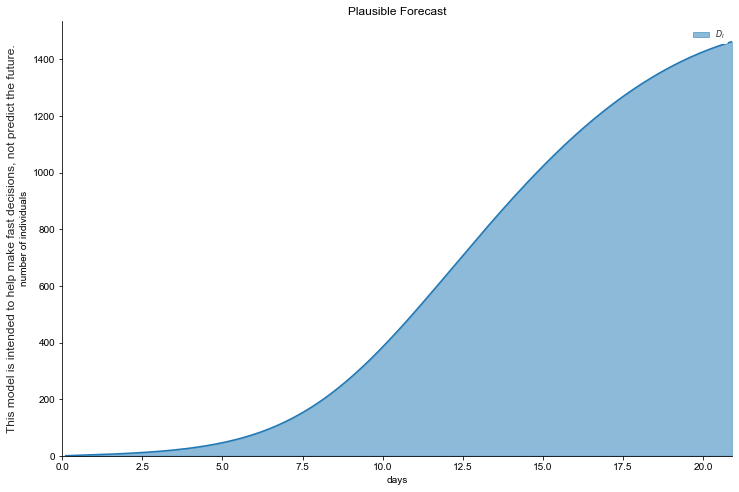

In [15]:
# hide_input
beta = 2.4
_, _, infection_results = get_risk_estimates(assam_estimated_df, beta=beta)
infection_results["model"].figure_infections(
    plot_percentages=False,
    plot_D_E=False,
    title="Plausible Forecast",
    #             title=f"Plausible Scenario for {district}. Population > {initN / 10**6:.2f} Million",
    side_title="This model is intended to help make fast decisions, not predict the future.",
    plot_E=False,
    plot_I=False,
    color_D_I="tab:blue",
)